<a href="https://colab.research.google.com/github/moaaz12-web/Multinet-multipose-estimation/blob/main/Multinet_multipose_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/nicknochnack/MultiPoseMovenetLightning.git

Cloning into 'MultiPoseMovenetLightning'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), 13.49 MiB | 15.33 MiB/s, done.


In [ ]:
!pip install tensorflow==2.5.0 tensorflow-hub opencv-python matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.4/454.4 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.4/462.4 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

In [ ]:
# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 6, (0,255,0), -1)
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 4)

# The order of the 17 keypoint joints is: [nose, left eye, right eye, left ear, right ear, left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist, left hip, right hip, left knee, right knee, left ankle, right ankle].

In [ ]:
cap = cv2.VideoCapture('/content/5.mp4')  # DIMESNION ARE (1080, 1920, 3)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Resize image
    img = frame.copy()


    img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
    input_img = tf.cast(img, dtype=tf.int32)
    
    # Detection section
    results = movenet(input_img)
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
    
    # Render keypoints 
    loop_through_people(frame, keypoints_with_scores, EDGES, 0.1)
    
    # cv2.imshow('Movenet Multipose', frame)
    
    # if cv2.waitKey(10) & 0xFF==ord('q'):
    #     break
cap.release()
cv2.destroyAllWindows()

(1080, 1920, 3)


In [ ]:
image_path = '/content/My project.jpg'
image = cv2.imread(image_path)

In [ ]:
image.shape

(1920, 1080, 3)

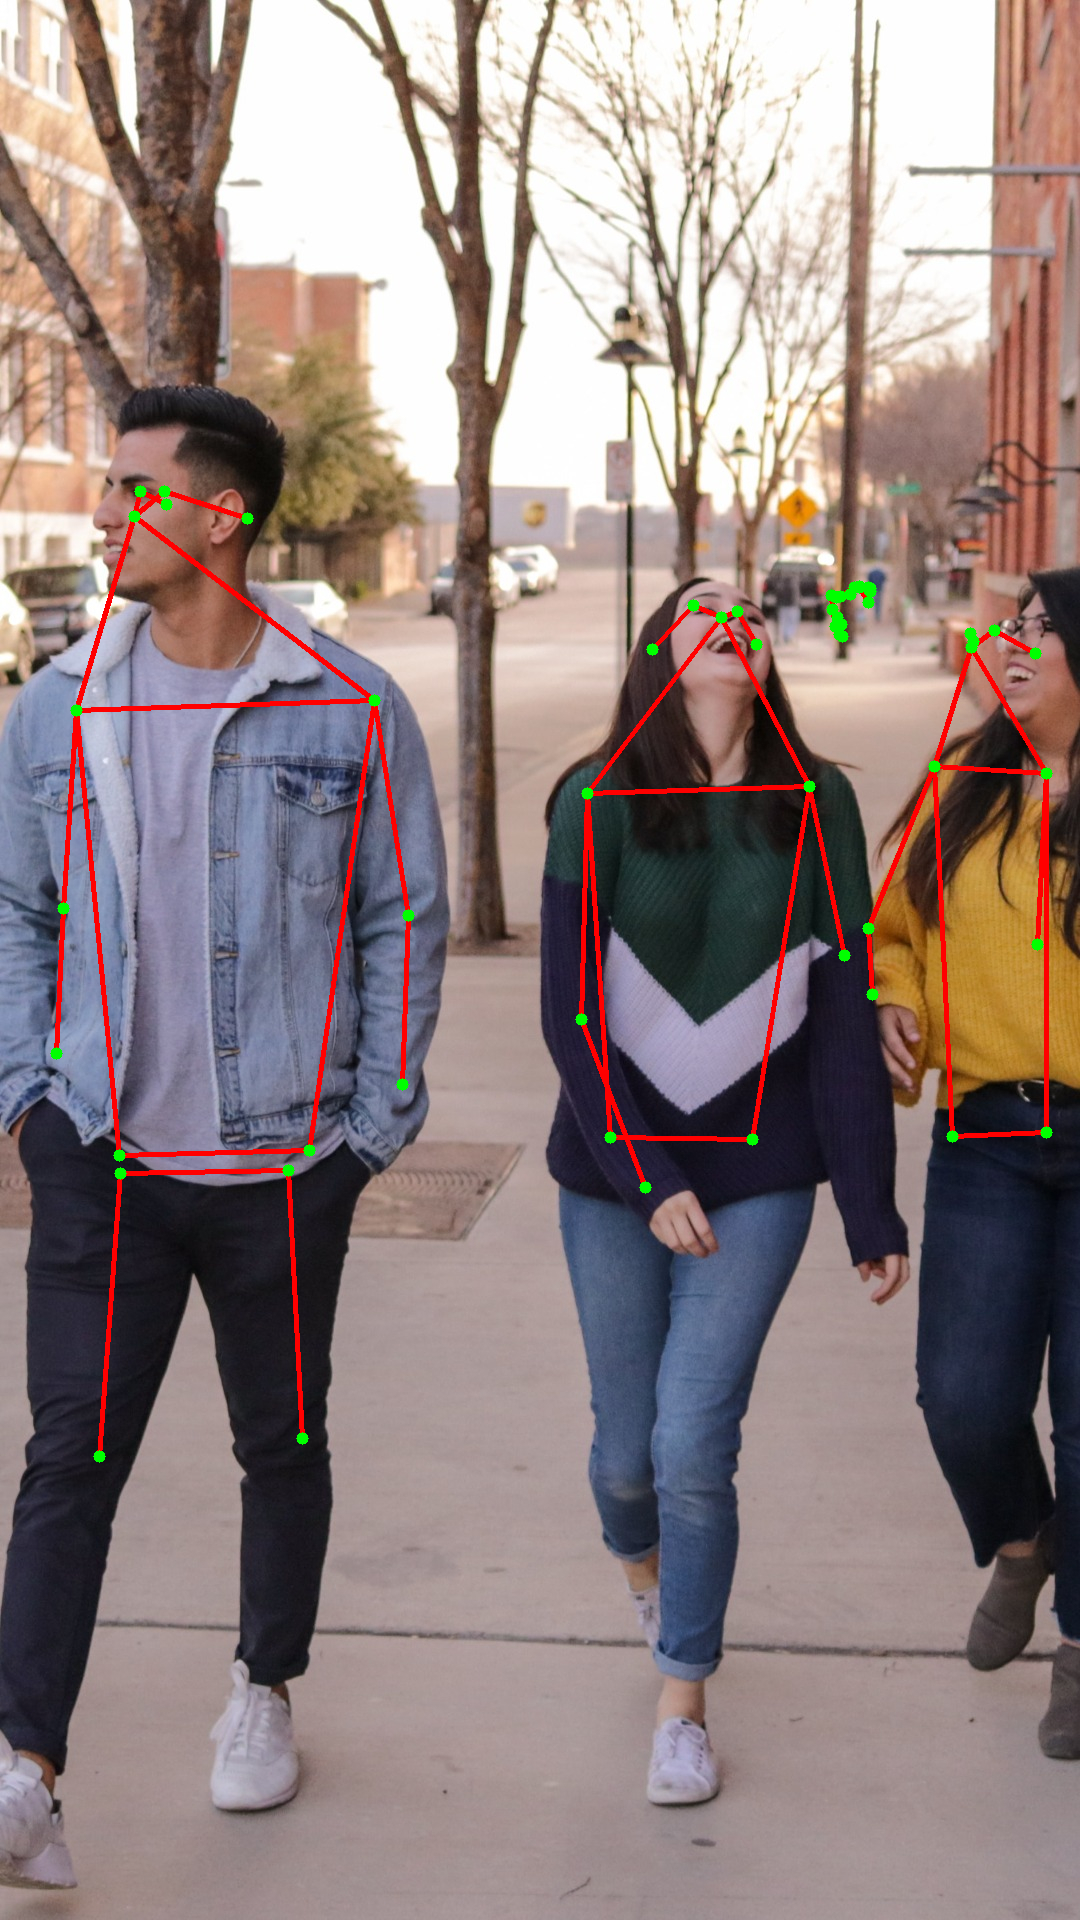

In [ ]:
import cv2
import tensorflow as tf
import numpy as np
from google.colab.patches import cv2_imshow

# Load the Movenet model

# Define the keypoints order
keypoints_order = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder',
                   'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist',
                   'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']

# Define the connections between the keypoints
keypoints_connections = [(0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6), (5, 7), (6, 8), (7, 9),
                         (8, 10), (5, 11), (6, 12), (11, 12), (11, 13), (12, 14), (13, 15), (14, 16)]

# Load the person's image
image_path = '/content/My project.jpg'  # DIMENSIONS ARE (1920, 1080, 3)
image = cv2.imread(image_path)


img = image.copy()
img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0),  640, 384)
input_img = tf.cast(img, dtype=tf.int32)

# Detection section
results = movenet(input_img)
keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))

# Render keypoints 
loop_through_people(image, keypoints_with_scores, EDGES, 0.1)

cv2_imshow(image)






In [ ]:
import json

# Assume the data is stored in a variable named 'data'
data = keypoints_with_scores
# Define the key names
import numpy as np
import json

# Assume the data is already in a numpy array called 'data'

# Create a dictionary to store the data
data_dict = {}

# Loop over the 6 people in the data
for i in range(6):
    person_data = {}
    # Loop over the 17 body parts for each person
    for j in range(17):
        part_name = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder',
                     'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist',
                     'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle'][j]
        part_data = data[i][j].tolist()
        # Convert float32 data to float
        part_data = [float(x) for x in part_data]
        person_data[part_name] = part_data
    # Add person data to the dictionary
    data_dict[f'person_{i+1}'] = person_data

# Save the dictionary as a JSON file
with open('data.json', 'w') as f:
    json.dump(data_dict, f)



In [ ]:
keypoints_with_scores[0]

array([[2.6899567e-01, 1.2479182e-01, 3.9482862e-01],
       [2.5614321e-01, 1.5232015e-01, 5.4412848e-01],
       [2.5584197e-01, 1.3011172e-01, 5.3818357e-01],
       [2.7029273e-01, 2.2942665e-01, 7.3229176e-01],
       [2.6299328e-01, 1.5426412e-01, 4.4728029e-01],
       [3.6502030e-01, 3.4700572e-01, 8.2519639e-01],
       [3.7018988e-01, 7.0501238e-02, 6.6367447e-01],
       [4.7699109e-01, 3.7798113e-01, 8.5196346e-01],
       [4.7294164e-01, 5.8510851e-02, 7.4886733e-01],
       [5.6484145e-01, 3.7236869e-01, 3.9275014e-01],
       [5.4869884e-01, 5.2717850e-02, 3.0437008e-01],
       [5.9941530e-01, 2.8664634e-01, 5.5336046e-01],
       [6.0192961e-01, 1.1056553e-01, 3.2008880e-01],
       [6.2045145e-01, 3.3392876e-01, 4.8396306e-04],
       [6.0144275e-01, 6.5767840e-02, 4.9106390e-03],
       [6.1960679e-01, 1.9575936e-01, 4.7204411e-03],
       [6.1123943e-01, 2.9794490e-01, 3.3530050e-03]], dtype=float32)